## Previous model content

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

In [12]:
data = pd.read_csv("Task 3 and 4_Loan_Data.csv").drop('customer_id', axis = 1)

In [13]:
data.head()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,0,5221.545193,3915.471226,78039.38546,5,605,0
1,5,1958.928726,8228.752520,26648.43525,2,572,1
2,0,3363.009259,2027.830850,65866.71246,4,602,0
3,0,4766.648001,2501.730397,74356.88347,5,612,0
4,1,1345.827718,1768.826187,23448.32631,6,631,0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   credit_lines_outstanding  10000 non-null  int64  
 1   loan_amt_outstanding      10000 non-null  float64
 2   total_debt_outstanding    10000 non-null  float64
 3   income                    10000 non-null  float64
 4   years_employed            10000 non-null  int64  
 5   fico_score                10000 non-null  int64  
 6   default                   10000 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 547.0 KB


In [15]:
# Going to run a simple logistic regression on this.

X = data.drop('default', axis=1)
y = data['default']

In [16]:
# Scaling
scaler = StandardScaler()

feature_columns = X.columns
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_columns)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.35, random_state=42, stratify=y)

In [18]:
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [19]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

## Quantizing based on k-means

In [21]:
# Extracting the fico scores
fico_scores = data['fico_score'].values.reshape(-1,1)
fico_scores

array([[605],
       [572],
       [602],
       ...,
       [596],
       [647],
       [757]], shape=(10000, 1))

In [22]:
# Quantized levels to test
k_values = [2, 4, 8, 16, 32]

In [23]:
mse_results = []
quantized_data_examples = {}

In [26]:
for k in k_values:
    # Innit kmeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    
    # Fit KMeans
    kmeans.fit(fico_scores)

    # Get the cluster centroids 
    quantization_levels = kmeans.cluster_centers_

    # Assign each original FICO score to its nearest centroid
    quantized_fico_scores = quantization_levels[kmeans.labels_]

    # Calculate MSE between original and quantized scores
    mse = mean_squared_error(fico_scores, quantized_fico_scores)
    mse_results.append((k, mse))

    print(f"K = {k}: MSE = {mse:.2f}")

    # Store an example of quantized data for visualization
    if k in [4, 8]:
        quantized_data_examples[k] = (fico_scores, quantized_fico_scores, quantization_levels)

K = 2: MSE = 1349.30
K = 4: MSE = 439.27
K = 8: MSE = 125.79
K = 16: MSE = 35.30
K = 32: MSE = 9.14


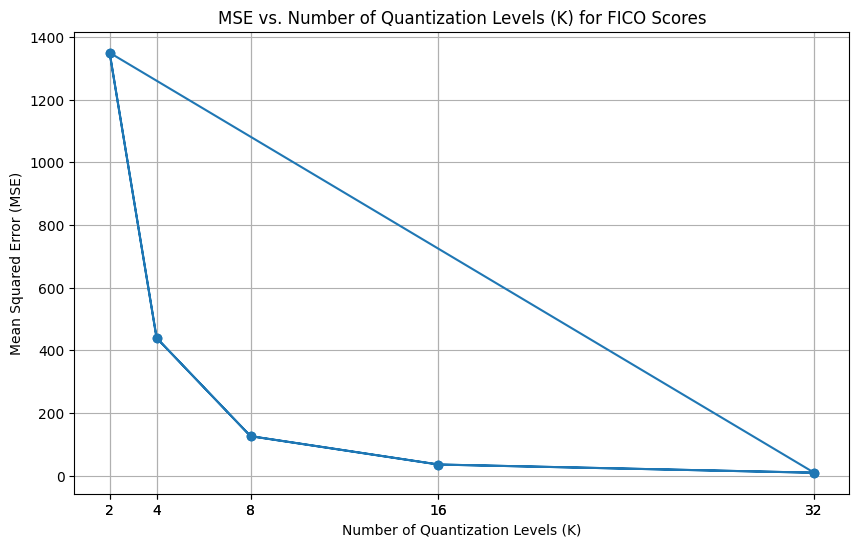

In [27]:
# Analyze the results (MSE vs. K)
k_values_mse = [res[0] for res in mse_results]
mse_values = [res[1] for res in mse_results]

plt.figure(figsize=(10, 6))
plt.plot(k_values_mse, mse_values, marker='o', linestyle='-')
plt.title('MSE vs. Number of Quantization Levels (K) for FICO Scores')
plt.xlabel('Number of Quantization Levels (K)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(k_values_mse)
plt.grid(True)
plt.show()

Looking at the graph, k=8 is probably the elbow point and should be considered for the number of bins